# Lensing observables and degeneracies

In this notebook, we are describing and experimenting with observables of gravitational lensing and degeneracies involved.

This notebook is self-constained but it is recommended to first go through the part I notebook.


In [12]:
!pip install lenstronomy  # tested with version 1.8.2
!pip install pyyaml==5.1
#!pip install corner

import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

from lenstronomy.Util import util

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/local/bin/python -m pip install --upgrade pip' command.


## Lensing image distortions

Lensing conserves surface brightness. Given a source with an intrinsic brightness profile $I^{s}(\boldsymbol{\beta})$, the lensed image(s) have the surface brightness profile

$$I(\boldsymbol{\theta}) = I^{s}[\boldsymbol{\beta}(\boldsymbol{\theta})],$$

where $\boldsymbol{\beta}(\boldsymbol{\theta})$ is the mapping according to the lens equation.

Instead of computing for a specific source position $\boldsymbol{\beta}$ where the images occur, it is (much) easier to start in the image plane $\boldsymbol{\theta}$ and map the coordinates back to the source plane.

### weak lensing distortions

Recap from notebook 1: The local lensing Jacobian is given by

$$ A_{ij} \equiv {\frac {\partial \beta _{i}}{\partial \theta _{j}}}
=\left[{\begin{array}{c c }1-\kappa -\gamma _{1}&\gamma _{2}\\\gamma _{2}&1-\kappa +\gamma _{1}\end{array}}\right].
$$

In the linear regime, the mapping between the image and the source plane can be written with a constant lensing Jacobian $\mathbf{A}$ as

$$ \boldsymbol{\beta} - \boldsymbol{\beta_0} = \mathbf{A}\left(\boldsymbol{\theta} - \boldsymbol{\theta_0}\right).
$$

In the linear regime, the inverse, the mapping from the source to the image plane, is analytical and given by

$$ \boldsymbol{\theta} - \boldsymbol{\theta_0} = \mathbf{A^1}\left(\boldsymbol{\beta} - \boldsymbol{\beta_0}\right).
$$


##### Round case:

A round source with radius $R$ will be mapped to an ellipse.

The major axis $R_a$ is given by
$$ R_a = \frac{R}{1 - \kappa - |\gamma|} = \frac{R}{(1-\kappa)(1-|g|)} $$
and the minor axis $R_b$ is given by
$$ R_b = \frac{R}{1 - \kappa + |\gamma|} = \frac{R}{(1-\kappa)(1+|g|)} $$
with $|\gamma| = \sqrt{\gamma_1^2 + \gamma_2^2}$ is the absolute shear strength and 

$$g = \frac{\gamma}{1-\kappa} $$
is the reduced shear strength.

We can alternatively write the shear components $\gamma_1$ and $\gamma_2$ as
$$\gamma_1 = |\gamma| \times \cos(2\phi_{\gamma})$$
$$\gamma_2 = |\gamma| \times \sin(2\phi_{\gamma})$$

where $\phi_{\gamma}$ is the shear angle along the major axis distortion from the x-axis in direction of the y-axis.

The axis ratio of the lensed source $q$ is
$$ q = \frac{R_a}{R_b} = \frac{1 + |g|}{1 - |g|}. $$

The appeared shape of a $\textit{known round}$ source leads to an estimate of the reduced shear
$$ |g| = \frac{1 - q}{1+ q} .$$

The ratio of appeared to intrinsic size in given by the convergence $\kappa$.


In [2]:
from IPython.display import Image
Image(url= "https://raw.githubusercontent.com/sibirrer/strong_lensing_lectures/main/Graphics/lensing_distortions.png", width=400, height=400)




Transformation of a round source and impact of convergence and shear on the image. Image from [Narayan & Bartelmann 1996](https://ui.adsabs.harvard.edu/abs/1996astro.ph..6001N/abstract).


##### elliptical case - shape noise:

If the intrinsic ellipticity is not known, then there is an ambiguity between the shape of the intrinsic source and the (linear) lensing effect. This is known as 'shape noise'.

In the following we are going to experiment with this degeneracy and define an ellipsoid and a linear lens model with shear and convergence and perform the lensing distortion.



We define the linear lensing distortions with $\kappa$, $\gamma_1$ and $\gamma_2$ and we explore the effects and degeneracies among these parameters.

For the ellipsoid, we chose a constant surface brightness within an elliptical radius $R$.
In lenstronomy the ellipticity is defined with the eccentricity moduli $(e_1, e_2)$ defined as

$$e_1 = \frac{1-q}{1+q} \cos(2\phi_I)$$
and 
$$e_2 = \frac{1-q}{1+q} \sin(2\phi_I),$$

where $q$ is the semi-minor to semi-major axis ratio of the profile and $\phi_I$ is the orientation angle of the major axis ratio relative to the x-axis.

The radius of the ellipsoid is defined as $r=\sqrt{qx^2 + y^2/q}$ where $x$ is along the semi-major axis $a$ and $y$ is along the semi-minor axis $b$.

The radius $R$ in this form is the product average $R=\sqrt{R_a R_b}$.



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


The total flux of the intrinsic source is 10007.662821618378 and of the lensed image 16669.252119672747 within the same aperture.


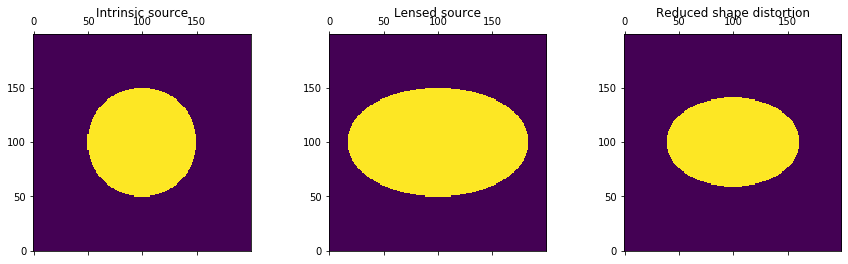

In [3]:

# define lens and light models
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
ellipsoid_light = LightModel(light_model_list=['ELLIPSOID'])
lens_linear = LensModel(lens_model_list=['SHEAR', 'CONVERGENCE'])

lens_reduced_shear = LensModel(lens_model_list=['SHEAR_REDUCED'])

# set up a 2d coordinate grid in the image plane
x_grid, y_grid = util.make_grid(numPix=200, deltapix=0.01)
x_grid = util.array2image(x_grid)
y_grid = util.array2image(y_grid)

# define source shape parameters
kwargs_ellipsoid_source = [{'amp': 1, 'radius': 0.5, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}]
# define linear lensing distortions
kwargs_lens_linear = [{'gamma1': 0.2, 'gamma2': 0},  # shear terms in Jacobian
                     {'kappa_ext': 0.2}  # convergence term in Jacobian
                     ]


# compute intrinsic source surface brightness profile
#flux_source = gauss_light.surface_brightness(x_grid, y_grid, kwargs_source)
flux_source = ellipsoid_light.surface_brightness(x_grid, y_grid, kwargs_ellipsoid_source)

# compute distorted surface brightness profile
# we compute the source coordinates for the corresponding image coordinates
beta_x_grid, beta_y_grid = lens_linear.ray_shooting(x_grid, y_grid, kwargs_lens_linear)
# we evaluate the surface brightness at these distorted coordinates
flux_image = ellipsoid_light.surface_brightness(beta_x_grid, beta_y_grid, kwargs_ellipsoid_source)

# and we repeat the exercise with reduced shear terms
beta_x_grid_red, beta_y_grid_red = lens_reduced_shear.ray_shooting(x_grid, y_grid, [kwargs_lens_linear[0]])
flux_image_reduced = ellipsoid_light.surface_brightness(beta_x_grid_red, beta_y_grid_red, kwargs_ellipsoid_source)

# we plot the intrinsic and distorted image

f, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].matshow(flux_source, origin='lower')
axes[0].set_title('Intrinsic source')

axes[1].matshow(flux_image, origin='lower')
axes[1].set_title('Lensed source')

axes[2].matshow(flux_image_reduced, origin='lower')
axes[2].set_title('Reduced shape distortion')

f.show()


print('The total flux of the intrinsic source is %s and of the lensed image %s within the same aperture.' % (np.sum(flux_source), np.sum(flux_image)))

Given that on large scales, galaxies are uncorrelated in their orientation, on $\textit{average}$ (in a stacking sense) galaxies are statistically round and the correlation of the $\textit{measured}$ shape is a signal of gravitational lensing called cosmic shear.

### generalized shape noise

To characterize general lensing degeneracies inherent in gravitational lensing, we define the following notation:
$\mathbf {L}$ is the lensing operator distorting the source, effectively mapping the lensed coordinates, $\boldsymbol{\theta}$, to the coordinates prior to lensing, $\boldsymbol{\beta}$. In general terms, $\mathbf {L}$ describes a coordinate mapping. The lens equation can be written in this notation as $\mathbf {L}(\boldsymbol{\theta}) = \boldsymbol{\theta} - \boldsymbol{\alpha}(\boldsymbol{\theta})$.
Given an intrinsic source morphology $\mathbf {S}$, such that $\mathbf {S}(\boldsymbol{\beta})$ describes the intrinsic surface brightness at position $\boldsymbol{\beta}$, the distorted image, $\mathbf {D}(\boldsymbol{\theta})$, can be written as
$$
\mathbf {D}(\boldsymbol{\theta}) = \mathbf {S}(\mathbf{L}(\boldsymbol{\theta})).
$$
In terms of the operator notation, $\mathbf {L}$ is acting on $\mathbf {S}$ resulting in $\mathbf {D}$, stating as 
$$
{\mathbf D} = \mathbf {L \circ S}.
$$

With this notation, we can describe the general invariance between lensing operator $\mathbf {L}$ and source morphology $\mathbf {S}$ resulting in the same image $\mathbf {D}$ with one single additional mapping operator $\mathbf {J}$, by expanding expression above with the unity operator (now written as $\mathbf {J}^{-1}\mathbf {J}$) as

$$
	{\mathbf D} = \mathbf {L \circ S} = \mathbf {L \circ} \mathbb{1} \mathbf {\circ S} 
	= \mathbf {L \circ  (J^{-1}  J) \circ S} \\
	= \mathbf {(L \circ  J^{-1})\circ  (J \circ S)} \equiv \mathbf{\tilde{L} \circ \tilde{S}}.
$$
In the last line, we defined the transformed deflection operator, $\mathbf {\tilde{L}} \equiv \mathbf {L \circ J^{-1}}$, and transformed source, $\mathbf {\tilde{S}} \equiv \mathbf {J \circ S}$, resulting in the same image $\mathbf {D}$.
The only formal requirement on $\mathbf {J}$ in the equation above is that the mapping is bijective and the inverse $\mathbf {J}^{-1}$ is uniquely defined over the extent of image $\mathbf {D}$.

In summary, for any bijective angular mapping operator $\mathbf {J}$, there exists an alternative solution to the lens equation,  ${\mathbf D} = \mathbf{\tilde{L} \circ \tilde{S}}$ with source $\mathbf {\tilde{S}} = \mathbf {J \circ S}$ and lens $\mathbf {\tilde{L}} = \mathbf {L \circ J^{-1}}$. This statement is an operator formulation of the Source Position Transform (SPT).

## multiple images

In the previous block we have discussed how a single image gets distorted under a linear lensing distortion. In this block, we generalize the concept and identify the invariant observables in the presence of $\textit{multiple}$ images in the strong lensing regime.

In [4]:
from IPython.display import Image
Image(url= "https://raw.githubusercontent.com/sibirrer/strong_lensing_lectures/main/Graphics/distortion_degeneracies.png", width=400, height=400)



Image from [Yang, Birrer, Treu 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.496.2648Y/abstract)

In the presence of two or more images, $\mathbf{D_i}$, $\mathbf{D_j}$, the relative operator translating one image into another can be determined without the knowledge of the intrinsic source $\mathbf{S}$:

$$
	\mathbf {D_j} = \mathbf {L_j \circ S} =  \mathbf {L_j \circ L_i^{-1} \circ D_i} = \mathbf {\tilde{L}_j \circ \tilde{L}_i^{-1} \circ D_i}.
$$
In short, the measurable quantity in lensing under the full consideration of the SPT is the relative distortion operator $\mathbf {L_j \circ L_i^{-1}}$ between two images of the same source.

Detailed discussions on observables and degeneracies can be found e.g. [in this work](https://arxiv.org/abs/2104.09522) (a bit biased by the author of this notebook) and with the accompanied [Jupyter notebooks](https://github.com/sibirrer/curved_arcs).

## mass sheet degeneracy

The mass-sheet transform (MST) is the scalar component of the general SPT ($\mathbf {J}$). This scalar component is a multiplicative transform of the lens equation preserving image positions (and thus any higher order differentials too) under a linear source displacement $\boldsymbol{\beta} \rightarrow \lambda\boldsymbol{\beta}$ and was introduced by [Falco et al. 1985](https://ui.adsabs.harvard.edu/abs/1985ApJ...289L...1F/abstract) [Gorenstein et al. 1988](https://ui.adsabs.harvard.edu/abs/1988ApJ...327..693G/abstract) as such

$$
  \lambda_{\rm MST} \boldsymbol{\beta} = \boldsymbol{\theta} - \lambda_{\rm MST} \boldsymbol{\alpha}(\boldsymbol{\theta}) - (1 - \lambda_{\rm MST}) \boldsymbol{\theta}.
$$
The term $(1 - \lambda_{\rm MST}) \boldsymbol{\theta}$ in the equation above describes an infinite sheet of convergence (or mass) and hence the name mass-sheet transform.
The corresponding transform of the convergence profile is given by
$$
  \kappa_{\rm MST}(\boldsymbol{\theta}) =  \lambda_{\rm MST} \kappa(\boldsymbol{\theta}) - (1 - \lambda_{\rm MST}).
$$

The MST can be described as a global transform of the convergence and hence it can lead to physical solutions for a wide range of values of $\lambda_{\rm MST}$. A fact that makes the MST a prominent and relevant degeneracy for many applications, in particular the measurement of the Hubble constant with time-delay cosmography [Schneider & Sluse 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559A..37S/abstract)[Birrer et al. 2016](https://ui.adsabs.harvard.edu/abs/2016JCAP...08..020B/abstract)[Sonnenfeld 2018](https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.4648S/abstract)[Kochanek 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.1725K/abstract)[Blum et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...892L..27B/abstract)[Birrer et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...643A.165B/abstract).
Only observables related to the absolute source size, intrinsic magnification of the lensed source, the absolute lensing potential, or the relative time delay when imposing a known cosmology with absolute distances, are able to break this degeneracies.

In the following we generate a strong lensing image of a near-Einstein ring and perform the MST and demonstrate that the relative observables are invariant.

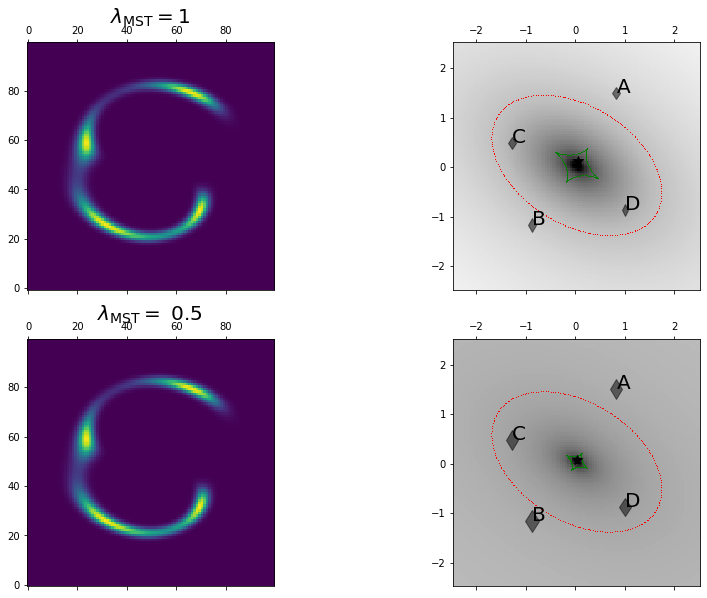

In [23]:
# set up lens model
from lenstronomy.LensModel.lens_model import LensModel
lens_model = LensModel(lens_model_list=['SIE', 'CONVERGENCE'])
kwargs_lens = [{'theta_E': 1.5, 'e1': 0.1, 'e2': -.2, 'center_x': 0, 'center_y': 0},
              {'kappa_ext': 0}]  # we start without a convergence (mass) sheet

# set up light model
from lenstronomy.LightModel.light_model import LightModel
light_model = LightModel(light_model_list=['GAUSSIAN_ELLIPSE'])
kwargs_source = [{'amp': 1, 'sigma': 0.1, 'e1': 0.4, 'e2': 0, 'center_x': 0.03, 'center_y': 0.1}]


def mst_transform(lambda_mst, kwargs_lens, kwargs_source):
    """
    transforms the parameters of the lens and source model according to the MST
    
    :param lambda_mst: scalar MST transform
    :kwargs_lens: keyword argument list of lens model parameters (in our case valid for a SIE model)
    :kwargs_source: keyword argument list of source model parameters (in our case an elliptical Gaussian)
    :return: transformed parameters under an MST
    """
    kwargs_lens_mst = copy.deepcopy(kwargs_lens)
    # scaling of lens model
    kwargs_lens_mst[0]['theta_E'] *= lambda_mst
    # adding a mass sheet
    kwargs_lens_mst[1]['kappa_ext'] = 1 - lambda_mst
    
    # scaling of source size
    kwargs_source_mst = copy.deepcopy(kwargs_source)
    kwargs_source_mst[0]['sigma'] *= lambda_mst
    kwargs_source_mst[0]['center_x'] *= lambda_mst
    kwargs_source_mst[0]['center_y'] *= lambda_mst
    return kwargs_lens_mst, kwargs_source_mst
    
    
# set up a 2d coordinate grid in the image plane
num_pix = 100
delta_pix = 0.05
x_grid, y_grid = util.make_grid(numPix=num_pix, deltapix=delta_pix)
x_grid = util.array2image(x_grid)
y_grid = util.array2image(y_grid)

# ==================
# system without MST
# ==================

# we compute the source coordinates for the corresponding image coordinates
beta_x_grid, beta_y_grid = lens_model.ray_shooting(x_grid, y_grid, kwargs_lens)
# we evaluate the surface brightness at these distorted coordinates
flux_image = light_model.surface_brightness(beta_x_grid, beta_y_grid, kwargs_source)



# ===============
# system with MST
# ===============

lambda_mst = 0.5

kwargs_lens_mst, kwargs_source_mst = mst_transform(lambda_mst, kwargs_lens, kwargs_source)

# we compute the source coordinates for the corresponding image coordinates
beta_x_grid_mst, beta_y_grid_mst = lens_model.ray_shooting(x_grid, y_grid, kwargs_lens_mst)
# we evaluate the surface brightness at these distorted coordinates
flux_image_mst = light_model.surface_brightness(beta_x_grid_mst, beta_y_grid_mst, kwargs_source_mst)


from lenstronomy.Plots.lens_plot import lens_model_plot

kwargs_lens_plot = {'with_caustics': True, 'fast_caustic': True, 'point_source': True,
                   'with_convergence': True, 'numPix': num_pix, 'deltaPix': delta_pix}

f, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].matshow(flux_image, origin='lower')
axes[0, 0].set_title(r'$\lambda_{\rm MST} = 1$', fontsize=20)

lens_model_plot(axes[0, 1], lens_model, kwargs_lens, 
                          sourcePos_x=kwargs_source[0]['center_x'], 
                          sourcePos_y=kwargs_source[0]['center_y'], **kwargs_lens_plot)

axes[1, 0].matshow(flux_image_mst, origin='lower')
axes[1, 0].set_title(r'$\lambda_{\rm MST} = $ %s' % lambda_mst, fontsize=20)

lens_model_plot(axes[1, 1], lens_model, kwargs_lens_mst, 
                          sourcePos_x=kwargs_source_mst[0]['center_x'], 
                          sourcePos_y=kwargs_source_mst[0]['center_y'], **kwargs_lens_plot)

plt.show()



## Summary

Gravitational lensing observables with multiple images are

- $\textit{relative}$ image positions
- $\textit{relative}$ time delays
- $\textit{relative}$ image distortions
- $\textit{relative}$ magnifications

Only when adding external knowledge about the intrinsic size, shape or brightness of an object, further information can be extracted.


